# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Цель исследования: построить модель машинного обучения, помогающую определить регион, где добыча принесет наибольшую прибыль.

Задачи:

    - обучить и проверить модель линейной регрессии для каждого региона.
    
    - рассчитать объем сырья для безубыточной разработки новой скважины;
    
    - посчитать риски и прибыль для каждого региона.
    
Описание данных:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

Загрузим необходимые библиотеки для работы с данными.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Считаем данные из csv-файлов `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv` и сохраним их в переменные `data_1`, `data_2`, `data_3` соотвественно.

In [4]:
try:
    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

In [5]:
try:
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

In [6]:
try:
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Выведем основную информацию о наших датафреймах с помощью методов `info()` и `head()`.

In [7]:
data={'Регион 1':data_1, 'Регион 2':data_2, 'Регион 3':data_3}

In [8]:
for k,v in data.items():
    print(k)
    print(v.head())
    print()
    print(v.info())
    print()

Регион 1
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Регион 2
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11

Проверим датафреймы на наличие дубликатов:

In [9]:
for k, v in data.items():
  print('Количество дубликатов', k, 'равно',v.duplicated().sum())

Количество дубликатов Регион 1 равно 0
Количество дубликатов Регион 2 равно 0
Количество дубликатов Регион 3 равно 0


Удалим из датасетов столбец 'id', поскольку очевидно уникальный идентификатор скважины не будет влиять на прогноз.

In [10]:
data_1 = data_1.drop(columns=['id'])
data_2 = data_2.drop(columns=['id'])
data_3 = data_3.drop(columns=['id'])

Проверим наш датасет на наличие коллинеарных признаков, для этого построим тепловую карту матрицы корреляции

Регион 1


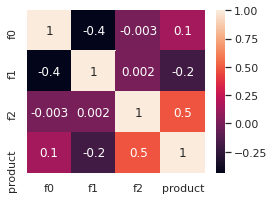

Регион 2


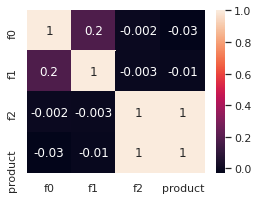

Регион 3


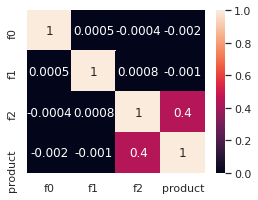

In [11]:
for k, v in data.items():
    print(k)
    sns.set(rc = {'figure.figsize':(4,3)})
    sns.heatmap(v.corr(), annot=True, fmt='.1g')
    plt.show();

По данной карте мы видим, что признаков с сильной корреляцией в наших данных нет (больших 0.6), также замечаем, что в регионе 2 присутствует сильная корелляция между признаком f2 и целевым признаком.

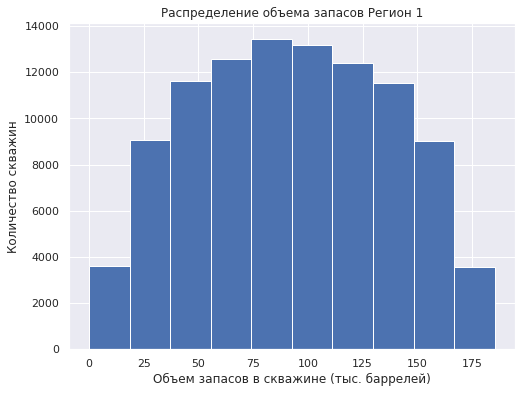

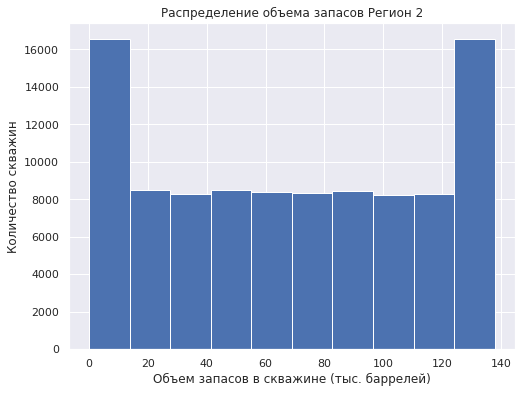

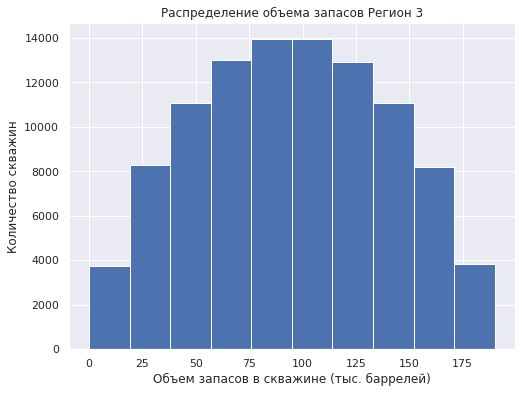

In [12]:
for k, v in data.items():
    message = f"Распределение объема запасов {k}"
    v['product'].plot(kind='hist', figsize=(8,6))
    plt.xlabel('Объем запасов в скважине (тыс. баррелей)')
    plt.ylabel('Количество скважин')
    plt.title(message)
    plt.show();

Замечаем, что распределение в регионе 2 разительно отличается и не является нормальным в отличие от распределений регионов 1 и 3.   

Разобьем наши данные на два датасета для каждого региона: сохраним признаки f_0, f_1, f_2 в переменных features_1, features_2 и features_3, а целевой признак product - в переменных target_1, target_2, target_3.

In [13]:
def features_target(data):
    features = data.drop(columns=['product'])
    target = data['product']
    return features, target    

In [14]:
features_1, target_1 = features_target(data_1)
features_2, target_2 = features_target(data_2)
features_3, target_3 = features_target(data_3)

Разделим датасеты data_1, data_2, data_3  на обучающую и валидационную выборки в соотношении 3:1 (75% и 25% соответственно). 

In [15]:
def train_valid(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [16]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_valid(features_1, target_1) 

In [17]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_valid(features_2, target_2)

In [18]:
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_valid(features_3, target_3)

Определим размерности обучающей и валидационной выборок.

In [19]:
for feat in [features_train_1, features_valid_1, features_train_2, features_valid_2, features_train_3, features_valid_3]:
    print(feat.shape)

(75000, 3)
(25000, 3)
(75000, 3)
(25000, 3)
(75000, 3)
(25000, 3)


Выводы: в данном разделе мы подготовили данные к машинному обучению.

- проверили наши данные на наличие дубликатов и пропущенных значений,

- удалили столбец 'id' которsq не влияет на значение целевого признака.

- изучили корреляцию признаков, увидели, что между признаками отсутствует сильная корреляция. Нет коэффициэнтов корреляции больше 0.6.

- в регионе 2 выявили сильную корелляцию между признаком f2 и целевым признаком.

- разделили наши данные на обучающую и валидационную выборки. В обучающую выборку попали 75000 наблюдений, в валидационную 25000 наблюдений.


## Обучение и проверка модели

Создадим функцию для инициализации линейной модели

In [20]:
def lin_regression(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predict_mean = predictions_valid.mean()
    result = mean_squared_error(target_valid, predictions_valid) ** (0.5)
    print(f'Средний запас предсказанного сырья {round(predict_mean,2)} тыс. баррелей')
    print(f"RMSE модели линейной регрессии на валидационной выборке: {round(result,2)}")
    return predictions_valid, round(predict_mean,2), round(result,2) 

In [21]:
print('Для региона 1:')
predictions_valid_1, predict_mean_1, result_1 = lin_regression(
    features_train_1, target_train_1, features_valid_1, target_valid_1)

Для региона 1:
Средний запас предсказанного сырья 92.59 тыс. баррелей
RMSE модели линейной регрессии на валидационной выборке: 37.58


In [22]:
print('Для региона 2:')
predictions_valid_2, predict_mean_2, result_2 = lin_regression(
    features_train_2, target_train_2, features_valid_2, target_valid_2)

Для региона 2:
Средний запас предсказанного сырья 68.73 тыс. баррелей
RMSE модели линейной регрессии на валидационной выборке: 0.89


In [23]:
print('Для региона 3:')
predictions_valid_3, predict_mean_3, result_3 = lin_regression(
    features_train_3, target_train_3, features_valid_3, target_valid_3)

Для региона 3:
Средний запас предсказанного сырья 94.97 тыс. баррелей
RMSE модели линейной регрессии на валидационной выборке: 40.03


Выводы: таким образом, делаем вывод, что модель линейной регрессии лучше всего работает на данных второго региона, поскольку значение RMSE минимально и равно 0.89, при этом средний запас предсказанного сырья в данном регионе тоже минимальный - 68.73 тыс. баррелей. Это может быть связано с тем, что распределение целевого признака региона 1 отлично от нормального и между признаком f_2 и целевым признаком есть сильная корреляция. Максимальный средний запас предсказанного сырья мы наблюдаем в регионе 3, его значение - 94.97 тыс. баррелей.  

## Подготовка к расчёту прибыли

Сохраним ключевые значения для расчётов в отдельных переменных.

In [24]:
BUDGET = 10_000_000_000 #бюджет на разработку
BOREHOLE_COUNT = 200 #количество отобранных скважин 
BARREL_RUB = 450_000 #доход в рублях на тысячу баррелей

Вычислим размер бюджета на одну скважину и достаточный объём сырья в тыс. баррелей для безубыточной разработки новой скважины.

In [25]:
BUDGET_BOREHOLE = BUDGET/BOREHOLE_COUNT
print('Размер бюджета на одну скважину', BUDGET_BOREHOLE, 'рублей')

Размер бюджета на одну скважину 50000000.0 рублей


In [26]:
BREAKEVEN_BARREL = BUDGET_BOREHOLE/BARREL_RUB
print('Достаточный объём сырья для безубыточной разработки новой скважины', round(BREAKEVEN_BARREL,2), 'тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей


Выводы: для безубыточной разработки необходимо, чтобы достаточный объем сырья в скважине был не меньше 111 тыс. баррелей, средние же предсказанные значения в регионах разработки значительно меньше и равны 92, 68, 96 соответственно в трех регионах. Значит нам нужно построить алгоритм поиска скважин с наибольшими предсказанными значениями объема сырья, чтобы обеспечить безубыточную разработку.    

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [30]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return BARREL_RUB * selected.sum() - BUDGET

Создадим функцию mean_revenue с встроенной техникой bootstrap, которая будет создавать 1000 выборок целевого признака, каждая из которых будет содержать по 500 значений. Среди этих 500 значений мы будем отбирать 200 с максимальными предсказанными значениями, и рассчитывать прибыль на данном наборе.   

In [31]:
def mean_revenue(target_valid, predictions_valid):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = pd.Series(target_valid).reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        probs_subsample = pd.Series(predictions_valid)[target_subsample.index]
        values.append(revenue(target_subsample,probs_subsample,BOREHOLE_COUNT))
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    loss = len(values[values < 0])/1000
    print(f'Средняя выручка {round(mean,0)} рублей')
    print(f"2,5%-квантиль: {lower}")
    print(f"97,5%-квантиль: {upper}")
    print(f"Риск убытка: {loss:.2%}")
    return mean, lower, upper, loss

Рассчитаем среднюю выручку, доверительный интервал и риск убытка для первого региона.

In [32]:
mean_1, lower_1, upper_1, loss_1 = mean_revenue(target_valid_1, predictions_valid_1)

Средняя выручка 425938527.0 рублей
2,5%-квантиль: -102090094.83793654
97,5%-квантиль: 947976353.3583689
Риск убытка: 6.00%


Рассчитаем среднюю выручку, доверительный интервал и риск убытка для второго региона.

In [33]:
mean_2, lower_2, upper_2, loss_2 = mean_revenue(target_valid_2, predictions_valid_2)

Средняя выручка 515222773.0 рублей
2,5%-квантиль: 68873225.37050176
97,5%-квантиль: 931547591.2570494
Риск убытка: 1.00%


Рассчитаем среднюю выручку, доверительный интервал и риск убытка для третьего региона.

In [34]:
mean_3, lower_3, upper_3, loss_3 = mean_revenue(target_valid_3, predictions_valid_3)

Средняя выручка 435008363.0 рублей
2,5%-квантиль: -128880547.32978901
97,5%-квантиль: 969706954.1802661
Риск убытка: 6.40%


Вывод: таким образом, для разработки скважин наиболее всего подходит  второй регион, поскольку в данном регионе мы получили максимальную среднюю выручку - более 515 млн. рублей, также риск отрицательной прибыли в данном регионе тоже минимальный - всего 1%.  

Общий вывод: в данном проекте нами в данном проекте нами были произведены следующие действия:
- подготовлены данные для построения модели машинного обучения:
    - проверены данные на наличие дубликатов;
    - удалены столбцы, невлияющие на значение целевого признака;
    - изучена корреляция признаков (сильная корреляция отсутствует);
    - данные разделены на обучающую, валидационную выборки в соотношении 3:1;
- для трех регионов обучены модели на алгоритме линейной регрессии, найдены средние запасы предсказанного сырья и значения метрики RSME . Максимальные значения среднего запаса предсказанного сырья (94.97) и метрики RSME (40.03) мы наблюдаем в регионе 3. Минимальные значения среднего запаса предсказанного сырья (68.73) и метрики RSME (0.89) в регионе 2, это значит, что модель линейной регрессии лучше всего работает на данных второго региона. 
- рассчитан достаточный объём сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей;
- найдены средняя выручка, доверительный интервал и риск убытка для трех регионов. Лучшие показатели у 2 региона: средняя выручка более 515 млн. рублей, доверительный интервал не содержит отрицательной прибыли, риск убытков - 1%, что удовлетворяет техническому заданию (меньше 2,5%) .

Рекомендации: с целью получения максимальной прибыли и минимизации убытков рекомендовано разрабатывать месторождения второго региона. 
